In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#import time
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load the data

In [2]:
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        # normolization
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget#

In [3]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

# training data
n_train = len(trainTarget)
trainData = np.reshape(trainData, [n_train, -1])

# validation data
n_valid = len(validTarget)
validData = np.reshape(validData, [n_valid, -1])

# testing data
n_test = len(testTarget)
testData = np.reshape(testData, [n_test, -1])

# Convert the data into a one-hot encoding format.

In [4]:
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [5]:
newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget)

In [6]:
def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target

# 1. Neural Networks using Numpy

# Implementation of a neural network using only Numpy - trained using gradient descent with momentum

## 1.1 Helper Functions

In [7]:
def relu(x):
    return np.maximum(0,x)

In [8]:
def softmax(x):
    """
    Computes a softmax function. 
    Input: A (N, 10) ndarray.
    Returns: (N, 10) ndarray.
    """
    e = np.exp(x - x.max(axis=0))
    y = e / np.sum(e, axis=1, keepdims=True)
    return y

In [9]:
def computeLayer(X, W, b):
    return np.dot(X,W)+b

In [10]:
def CE(target, prediction):
    #print("prediction")
    #print(np.log(prediction[0]))
    L_sum = np.sum(target*np.log(prediction+10**-10))
    n = target.shape[0]
    L = (-1)*(1./n) * L_sum
    return L

In [11]:
def gradCE(target, prediction):
    return prediction-target

## 1.2 Backpropagation Derivation

• gradient of the loss with respect to the outer layer weights.

In [12]:
def grad_out_w(X_h,delta_out):
    return np.dot(X_h.T,delta_out)

• gradient of the loss with respect to the outer layer biases.

In [13]:
def grad_out_b(delta_out):
    return np.sum(delta_out,axis=0,keepdims=True)

• gradient of the loss with respect to the hidden layer weights.

In [14]:
def grad_hidden_w(X,delta_hidden):
    return np.dot(X.T,delta_hidden)

• gradient of the loss with respect to the hidden layer biases.

In [15]:
def grad_hidden_b(delta_hidden):
    return np.sum(delta_hidden,axis=0,keepdims=True)

• gradient of the Relu.

In [16]:
def grad_relu(z):
    """Derivative of the relu function."""
    return np.where(z > 0, 1.0, 0.0)

## 1.3 Learning

### Initialize parameters

In [17]:
gamma = 0.9
alpha =  10**-7
epochs = 200

In [18]:
def initialization(trainData,newtrain,hidden_units):
        
    samples = trainData.shape[0]
    features = trainData.shape[1]
    classes = newtrain.shape[1]

    variance_xavier_hidden = 2./(hidden_units+features)
    variance_xavier_out = 2./(hidden_units+classes)

    W_hidden = np.random.normal(0, variance_xavier_hidden, size=(features,hidden_units))
    b_hidden = np.random.normal(0, variance_xavier_hidden, size=(1,hidden_units))

    v_w_hidden = np.full((features, hidden_units), 10**-5)
    v_b_hidden = np.full((1, hidden_units), 10**-5)

    W_out = np.random.normal(0, variance_xavier_out, size=(hidden_units,classes))
    b_out = np.random.normal(0, variance_xavier_hidden, size=(1,classes))

    v_w_out = np.full((hidden_units, classes), 10**-5)
    v_b_out = np.full((1, classes), 10**-5)
    
    return W_hidden,b_hidden,W_out,b_out,v_w_hidden,v_b_hidden,v_w_out,v_b_out


In [19]:
def computation(data,W_hidden, b_hidden,W_out, b_out):
    # hidden layer
    Z_h = computeLayer(data, W_hidden, b_hidden)
    X_h = relu(Z_h)
     
    # output layer
    Z_o = computeLayer(X_h, W_out, b_out)
    Y_o = softmax(Z_o)
    
    return Z_h,X_h,Y_o

In [25]:
def training(trainData,newtrain,validData,newvalid,testData,newtest,hidden_units,gamma,alpha):
    loss_train_set = []
    loss_valid_set = []
    loss_test_set = []
    
    accuracy_train_set = []
    accuracy_valid_set = []
    accuracy_test_set = []
    
    epochs_set = []
    
    W_hidden,b_hidden,W_out,b_out,v_w_hidden,v_b_hidden,v_w_out,v_b_out = \
    initialization(trainData,newtrain,hidden_units)
     
    
    for epoch in range(epochs+1):
        # forward pass
        
        Z_h_train,X_h_train,Y_o_train = computation(trainData,W_hidden, b_hidden,W_out, b_out)

        Y_o_valid = computation(validData,W_hidden, b_hidden,W_out, b_out)[-1]
        Y_o_test = computation(testData,W_hidden, b_hidden,W_out, b_out)[-1]
        
    
        # backward pass
        delta_out = Y_o_train - newtrain
        delta_hidden = grad_relu(Z_h_train)*np.dot(delta_out,W_out.T)
                          
        # gradient descent with momentum
        v_w_out = gamma*v_w_out + alpha*grad_out_w(X_h_train,delta_out)
        v_w_hidden = gamma*v_w_hidden + alpha*grad_hidden_w(trainData,delta_hidden)
    
        v_b_out = gamma*v_b_out + alpha*grad_out_b(delta_out)
        v_b_hidden = gamma*v_b_hidden + alpha*grad_hidden_b(delta_hidden)
    
        # update weights
        W_out = W_out - v_w_out
        W_hidden = W_hidden - v_w_hidden
 
        # updata biaes
        b_out = b_out - v_b_out
        b_hidden = b_hidden - v_b_hidden                                   
    
        epochs_set.append(epoch)
            
        loss_train = CE(newtrain, Y_o_train)
        loss_valid = CE(newvalid, Y_o_valid)
        loss_test = CE(newtest, Y_o_test)

        loss_train_set.append(loss_train)
        loss_valid_set.append(loss_valid)
        loss_test_set.append(loss_test)
            
        accuracy_train = np.equal(np.argmax(newtrain, axis=-1), np.argmax(Y_o_train, axis=-1)).mean()
        accuracy_valid = np.equal(np.argmax(newvalid, axis=-1), np.argmax(Y_o_valid, axis=-1)).mean()
        accuracy_test = np.equal(np.argmax(newtest, axis=-1), np.argmax(Y_o_test, axis=-1)).mean()
            
        accuracy_train_set.append(accuracy_train)
        accuracy_valid_set.append(accuracy_valid)
        accuracy_test_set.append(accuracy_test)
            
        if epoch % 20  == 0:
            print("Epoch: %d - Train Loss function value: %.4f - Train Accuracy: %.4f" %(epoch, loss_train, accuracy_train))
            print("Epoch: %d - Valid Loss function value: %.4f - Valid Accuracy: %.4f" %(epoch, loss_valid, accuracy_valid))
            print("Epoch: %d - Test Loss function value: %.4f - Test Accuracy: %.4f" %(epoch, loss_test, accuracy_test))
            
            #print("Epoch: %d - Test Accuracy: %.4f" %(epoch, accuracy_test))
    
    fig = plt.figure()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(epochs_set,loss_train_set,color='red', linewidth=1.5,label="Train Data")
    plt.plot(epochs_set,loss_valid_set,color='blue', linewidth=1.5,label="Valid Data")
    plt.plot(epochs_set,loss_valid_set,color='green', linewidth=1.5,label="Test Data")
    
    plt.title('Neural Network Loss') 
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.show()
    
    fig = plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epochs_set,accuracy_train_set,color='red', linewidth=1.5,label="Train Data")
    plt.plot(epochs_set,accuracy_valid_set,color='blue', linewidth=1.5,label="Valid Data")
    plt.plot(epochs_set,accuracy_test_set,color='green', linewidth=1.5,label="Test Data")

    plt.title('Neural Network Accurary')
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.show()              
   

Epoch: 0 - Train Loss function value: 2.3026 - Train Accuracy: 0.1127
Epoch: 0 - Valid Loss function value: 2.3026 - Valid Accuracy: 0.0842
Epoch: 0 - Test Loss function value: 2.3026 - Test Accuracy: 0.0863
Epoch: 20 - Train Loss function value: 2.3024 - Train Accuracy: 0.3369
Epoch: 20 - Valid Loss function value: 2.3024 - Valid Accuracy: 0.2917
Epoch: 20 - Test Loss function value: 2.3024 - Test Accuracy: 0.3443
Epoch: 40 - Train Loss function value: 2.3021 - Train Accuracy: 0.5476
Epoch: 40 - Valid Loss function value: 2.3021 - Valid Accuracy: 0.5167
Epoch: 40 - Test Loss function value: 2.3021 - Test Accuracy: 0.5470
Epoch: 60 - Train Loss function value: 2.3017 - Train Accuracy: 0.6242
Epoch: 60 - Valid Loss function value: 2.3018 - Valid Accuracy: 0.6173
Epoch: 60 - Test Loss function value: 2.3017 - Test Accuracy: 0.6380
Epoch: 80 - Train Loss function value: 2.3013 - Train Accuracy: 0.6587
Epoch: 80 - Valid Loss function value: 2.3013 - Valid Accuracy: 0.6630
Epoch: 80 - Test 

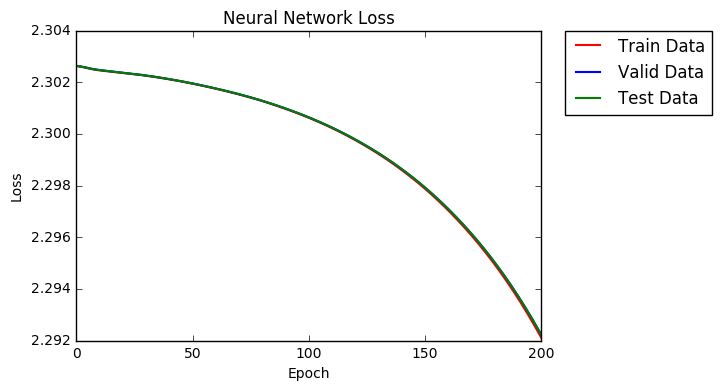

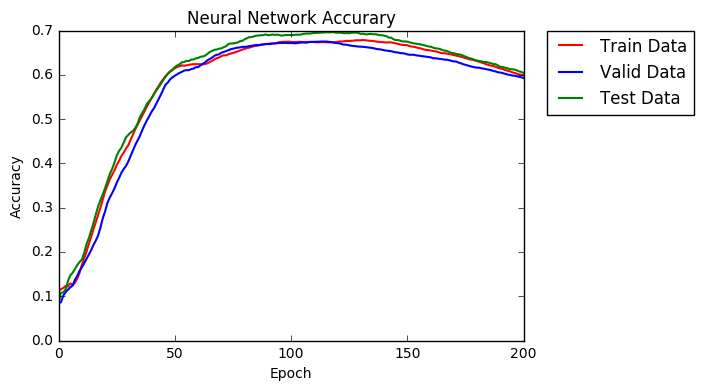

In [23]:
hidden_units = 1000
training(trainData,newtrain,validData,newvalid,testData,newtest,hidden_units,gamma,alpha)

## 1.4 Hyperparameter Investigation

### • Number of hidden units

hidden units = 100 
Epoch: 0 - Train Loss function value: 2.3019 - Train Accuracy: 0.1339
Epoch: 0 - Valid Loss function value: 2.3019 - Valid Accuracy: 0.1330
Epoch: 0 - Test Loss function value: 2.3019 - Test Accuracy: 0.1186
Epoch: 20 - Train Loss function value: 2.2974 - Train Accuracy: 0.4066
Epoch: 20 - Valid Loss function value: 2.2974 - Valid Accuracy: 0.3850
Epoch: 20 - Test Loss function value: 2.2974 - Test Accuracy: 0.3792
Epoch: 40 - Train Loss function value: 2.2880 - Train Accuracy: 0.4717
Epoch: 40 - Valid Loss function value: 2.2880 - Valid Accuracy: 0.4598
Epoch: 40 - Test Loss function value: 2.2880 - Test Accuracy: 0.4556
Epoch: 60 - Train Loss function value: 2.2759 - Train Accuracy: 0.4654
Epoch: 60 - Valid Loss function value: 2.2760 - Valid Accuracy: 0.4777
Epoch: 60 - Test Loss function value: 2.2760 - Test Accuracy: 0.4853
Epoch: 80 - Train Loss function value: 2.2611 - Train Accuracy: 0.4831
Epoch: 80 - Valid Loss function value: 2.2612 - Valid Accuracy: 0.49

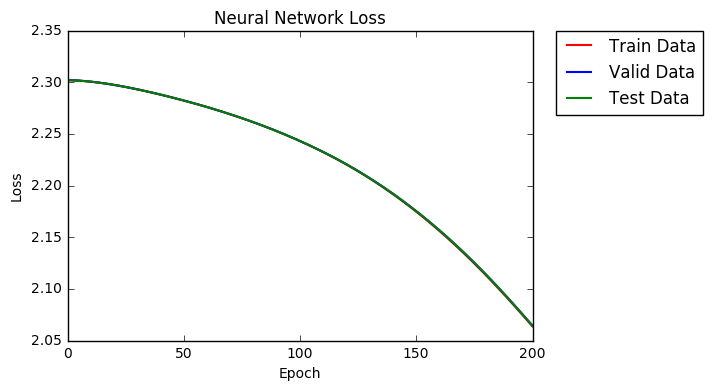

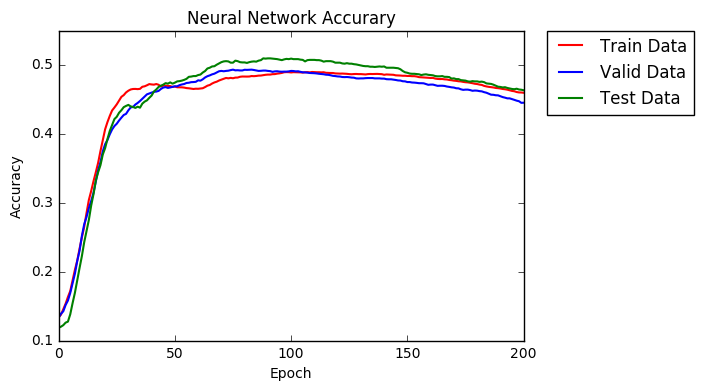

In [26]:
hidden_units_set = [100, 500, 2000]

print("hidden units = 100 ")
training(trainData,newtrain,validData,newvalid,testData,newtest,100,gamma,alpha)

hidden units = 500 
Epoch: 0 - Train Loss function value: 2.3026 - Train Accuracy: 0.1249
Epoch: 0 - Valid Loss function value: 2.3025 - Valid Accuracy: 0.1167
Epoch: 0 - Test Loss function value: 2.3025 - Test Accuracy: 0.1351
Epoch: 20 - Train Loss function value: 2.3019 - Train Accuracy: 0.4030
Epoch: 20 - Valid Loss function value: 2.3019 - Valid Accuracy: 0.3818
Epoch: 20 - Test Loss function value: 2.3019 - Test Accuracy: 0.3899
Epoch: 40 - Train Loss function value: 2.3009 - Train Accuracy: 0.5784
Epoch: 40 - Valid Loss function value: 2.3010 - Valid Accuracy: 0.5773
Epoch: 40 - Test Loss function value: 2.3009 - Test Accuracy: 0.5899
Epoch: 60 - Train Loss function value: 2.2996 - Train Accuracy: 0.6132
Epoch: 60 - Valid Loss function value: 2.2997 - Valid Accuracy: 0.6063
Epoch: 60 - Test Loss function value: 2.2996 - Test Accuracy: 0.6384
Epoch: 80 - Train Loss function value: 2.2979 - Train Accuracy: 0.6195
Epoch: 80 - Valid Loss function value: 2.2980 - Valid Accuracy: 0.61

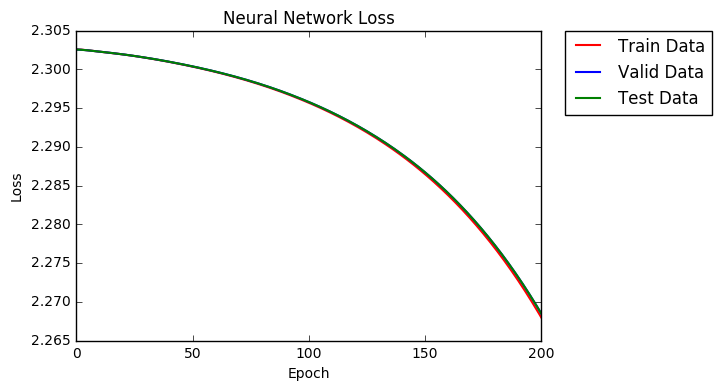

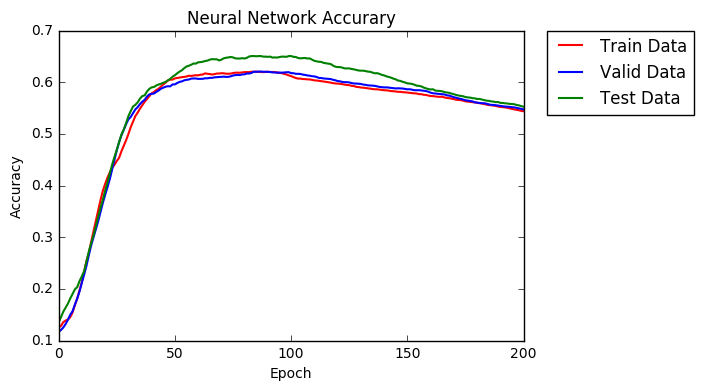

In [27]:
print("hidden units = 500 ")
training(trainData,newtrain,validData,newvalid,testData,newtest,500,gamma,alpha)

hidden units = 2000 
Epoch: 0 - Train Loss function value: 2.3027 - Train Accuracy: 0.0548
Epoch: 0 - Valid Loss function value: 2.3027 - Valid Accuracy: 0.0537
Epoch: 0 - Test Loss function value: 2.3027 - Test Accuracy: 0.0679
Epoch: 20 - Train Loss function value: 2.3026 - Train Accuracy: 0.1848
Epoch: 20 - Valid Loss function value: 2.3026 - Valid Accuracy: 0.1592
Epoch: 20 - Test Loss function value: 2.3026 - Test Accuracy: 0.1839
Epoch: 40 - Train Loss function value: 2.3026 - Train Accuracy: 0.2487
Epoch: 40 - Valid Loss function value: 2.3026 - Valid Accuracy: 0.2300
Epoch: 40 - Test Loss function value: 2.3026 - Test Accuracy: 0.2386
Epoch: 60 - Train Loss function value: 2.3025 - Train Accuracy: 0.2949
Epoch: 60 - Valid Loss function value: 2.3025 - Valid Accuracy: 0.3222
Epoch: 60 - Test Loss function value: 2.3025 - Test Accuracy: 0.3175
Epoch: 80 - Train Loss function value: 2.3025 - Train Accuracy: 0.3723
Epoch: 80 - Valid Loss function value: 2.3025 - Valid Accuracy: 0.3

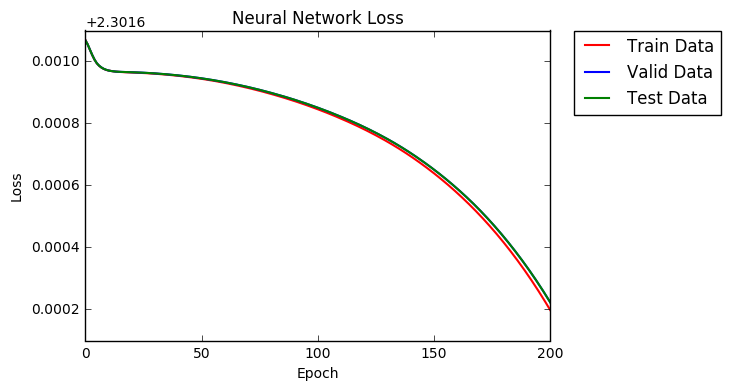

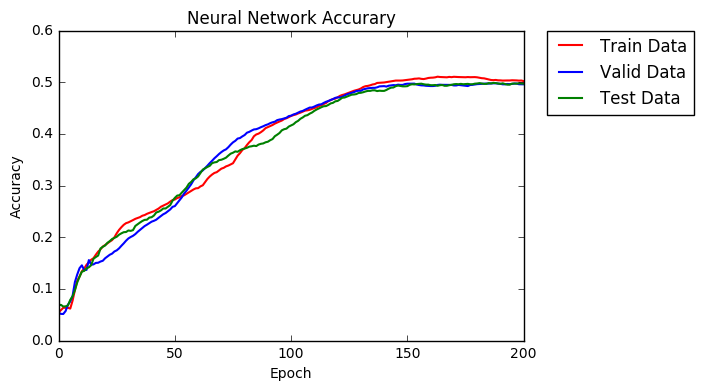

In [28]:
print("hidden units = 2000 ")
training(trainData,newtrain,validData,newvalid,testData,newtest,2000,gamma,alpha)

### • Early stopping

 From the plot of 1.3, when the point epoch = 100, the accuracies strating decreasing

# 2. Neural Networks in Tensorflow

## 2.1 Model implementation 

In [7]:
trainData = np.reshape(trainData, (-1, 28, 28, 1))
testData = np.reshape(testData, (-1, 28, 28, 1))
validData = np.reshape(validData, (-1, 28, 28, 1))

### • Initialization parameters

In [8]:
# the number output units of the fully connected layer 1
out_units_layer1 = 784
# the number output units of the fully connected layer 2
out_units_layer2 = 10
    
# Convolutional Layer 1
filter_size = 3          # Convolution filters are 5 x 5 pixels.
filter_number = 32         # There are 16 of these filters.

stride = 1
# max pooling layer
pooling_size = 2

### • Helper-function for creating a new Convolutional Layer

In [9]:
def conv_layer(X, filter_size, filter_number, stride, name):
    with tf.variable_scope(name,reuse=tf.AUTO_REUSE):
        # 3*3 convelotional layer with 32 filters
        # initialize filter
        # initialize with Xavier scheme
        with tf.variable_scope('filter',reuse=tf.AUTO_REUSE):
            W_filter = tf.get_variable("W_filter", shape=[filter_size, filter_size, 1, filter_number],initializer=tf.contrib.layers.xavier_initializer(uniform=False))
            b_filter = tf.get_variable("b_filter", shape=[filter_number],initializer=tf.zeros_initializer())
            layer = tf.nn.conv2d(X, W_filter, strides=[1, stride, stride, 1], padding="SAME")
            layer += b_filter
            # using relu function 
            return tf.nn.relu(layer),W_filter

### • Helper functions for creating a batch normalization layer

In [10]:
def batch_layer(X):
    # Calculate batch mean and variance
    mean, var = tf.nn.moments(X,[0,1,2])
    # normalize
    return tf.nn.batch_normalization(X, mean, var, 0, 1, 1e-3)

### Helper-function for creating a new Max-pooling Layer

In [11]:
def max_pool(X, pooling_size, stride, name):
    # using 2*2 max pooling
    return tf.nn.max_pool(X,
                          ksize=[1, pooling_size, pooling_size, 1],
                          strides=[1, stride, stride, 1],
                          padding="SAME",
                          name=name)

### Helper-function for creating a new flatten Layer

In [27]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

### • Helper functions for a new creating connected layers

In [28]:
def fc_layer(X, num_units, name,use_relu=True,use_dropout=False,p=None):
    
    with tf.variable_scope(name,reuse=tf.AUTO_REUSE):
        in_dim = X.get_shape()[1]
        
        W = tf.get_variable("W", dtype=tf.float32,
                            shape=[in_dim, num_units],
                            initializer=tf.contrib.layers.xavier_initializer(uniform=False))

        b = tf.get_variable("b", dtype=tf.float32,
                            shape=[num_units],
                            initializer=tf.zeros_initializer())

        layer = tf.matmul(X, W)
        layer += b
        
        if use_dropout:
            # dropout 
            print('dropout probability = ')
            print(p)
            layer = tf.nn.dropout(layer,p)
            
        if use_relu:
            layer = tf.nn.relu(layer)

        else:
            layer = tf.nn.softmax(layer)

        return layer,W

## Network graph

In [29]:
def buildGraph(weight_decay,filter_size, filter_number, stride,pooling_size,out_units_layer1,out_units_layer2,
               use_dropout=False,use_l2=False,p=None): 
    
    X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='X')
    y = tf.placeholder(tf.float32, shape=[None, 10], name='Y')
    
    # convelutional layer
    conv,conv_W = conv_layer(X, filter_size, filter_number, stride, name='conv')

    # batch normalization layer
    batch_norm = batch_layer(conv)

    #max_pooling layer
    pool = max_pool(batch_norm, pooling_size, stride, name='pooling')

    # flatten layer
    layer_flat = flatten_layer(pool)

    # first fully-connected layer
    fc1,fc1_W = fc_layer(layer_flat, out_units_layer1, 'FC1', use_relu=True,use_dropout=use_dropout,p=p)

    # second fully-connected layer(output layer)
    output_logits,fc2_W = fc_layer(fc1, out_units_layer2, 'OUT', use_relu=False,use_dropout=False,p=None)
    
    with tf.variable_scope('loss',reuse=tf.AUTO_REUSE):
        # caculate cross-entropy loss
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
    
        reg = 0.0
        if use_l2:
            # L2 loss
            print("weight decay = ")
            print(weight_decay)
            
            weights = [conv_W,fc1_W,fc2_W]
            for weight in weights:
                reg += tf.nn.l2_loss(weight)
        
            loss = loss + reg * weight_decay
    

    # define optimizer to minimize the loss
    #optimizer = tf.train.AdamOptimizer(learning_rate=10**-4, name='Adam-op').minimize(loss)

        AdamWOptimizer = tf.contrib.opt.extend_with_decoupled_weight_decay(tf.train.AdamOptimizer)
        optimizer = AdamWOptimizer(weight_decay=weight_decay, learning_rate=10**-4).minimize(loss,name='training_operation')

        # caculate accuracy
        correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    
        return X,y,loss,accuracy,optimizer


## 2.2 Model Training

In [30]:
def train(trainData,newtrain,validData,newvalid,testData,newtest,weight_decay,filter_size, filter_number, 
                                         stride,pooling_size,out_units_layer1,out_units_layer2,use_dropout=False,use_l2=False,p=None):
    batch_size = 32
    epochs = 50
    # define the number of batch
    batch_count = int(len(newtrain) / batch_size)

    X,y,loss,accuracy,optimizer = buildGraph(weight_decay,filter_size, filter_number, 
                                         stride,pooling_size,out_units_layer1,out_units_layer2,use_dropout,use_l2,p)
    
    # Initialize all variables
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        # Run the initializer
        sess.run(init)
    
        # Initialize plotting coordinates
        epoch_set = []

        trainLoss_set  = []
        validLoss_set  = []
        testLoss_set  = []
        
        trainAccuracy_set = []
        validAccuracy_set = []
        testAccuracy_set = []
    
        # run each epoch
        for epoch in range(epochs):
            trainData, newtrain = shuffle(trainData, newtrain)
        
            # run each batch
            for batch_index in range(batch_count):
            
                batch_X = trainData[batch_index*batch_size :(batch_index +1)*batch_size]
                batch_y = newtrain[batch_index*batch_size :(batch_index +1)*batch_size] 
                # Run optimization op (backprop)
                feed_dict_batch = {X: batch_X, y: batch_y}
                sess.run(optimizer, feed_dict=feed_dict_batch)

    
            # Calculate and display the batch loss and accuracy
            feed_dict_train = {X: trainData, y: newtrain}
            feed_dict_valid = {X: validData, y: newvalid }
            feed_dict_test = {X: testData, y: newtest}
            
            loss_train, acc_train = sess.run([loss, accuracy],feed_dict=feed_dict_train)
            loss_valid, acc_valid = sess.run([loss, accuracy],feed_dict=feed_dict_valid)
            loss_test, acc_test = sess.run([loss, accuracy],feed_dict=feed_dict_test)
            
            # Update the coordinates
            epoch_set.append(epoch)
            
            trainLoss_set.append(loss_train)
            validLoss_set.append(loss_valid)
            testLoss_set.append(loss_test)
            
            trainAccuracy_set.append(acc_train)
            validAccuracy_set.append(acc_valid)
            testAccuracy_set.append(acc_test)
                
            if epoch%5 == 0:
                print("epoch {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                      format(epoch, loss_train, acc_train))
                print("epoch {0:3d}:\t Loss={1:.2f},\tValidation Accuracy={2:.01%}".
                      format(epoch, loss_valid, acc_valid))
                print("epoch {0:3d}:\t Loss={1:.2f},\tTesting Accuracy={2:.01%}".
                      format(epoch, loss_test, acc_test))

            
    # loss curve   
    fig = plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss/CE")

    plt.plot(epoch_set,trainLoss_set,color='red', linewidth=1.5,label="training data")
    plt.plot(epoch_set,validLoss_set,color='blue', linewidth=1.5,label="validation data")
    plt.plot(epoch_set,testLoss_set,color='green', linewidth=1.5,label="testing data")

    plt.title('Convilutional Neural Network'+'/Loss')
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.show()
    
    # accuracy curve
    fig = plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy/percent")

    plt.plot(epoch_set,trainAccuracy_set,color='red', linewidth=1.5,label="training data")
    plt.plot(epoch_set,validAccuracy_set,color='blue', linewidth=1.5,label="validation data")
    plt.plot(epoch_set,testAccuracy_set,color='green', linewidth=1.5,label="testing data")

    plt.title('Convilutional Neural Network'+'/Accuracy')
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.show()


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

epoch   0:	 Loss=1.67,	Training Accuracy=79.1%
epoch   0:	 Loss=1.69,	Validation Accuracy=77.2%
epoch   0:	 Loss=1.68,	Testing Accuracy=78.0%
epoch   5:	 Loss=1.62,	Training Accuracy=84.6%
epoch   5:	 Loss=1.64,	Validation Accuracy=82.0%
epoch   5:	 Loss=1.64,	Testing Accuracy=81.6%
epoch  10:	 Loss=1.61,	Training Accuracy=85.0%
epoch  10:	 Loss=1.64,	Validation Accuracy=81.8%
epoch  10:	 Loss=1.64,	Testing Accuracy=82.1%
epoch  15:	 Loss=1.61,	Training Accuracy=85.5%
epoch  15:	 Loss=1.64,	Validation Accuracy=82.2%
epoch  15:	 Loss=1.64,	Testing Accuracy=82.1%
epoch  20:	 Loss=1.60,	Training Accuracy=86.2%
epoch  20:	 Loss=1.64,	Validation Accuracy=82.5%
epoch  20:	 Loss=1.63,	Testing Accuracy=82.7%
epoch  25:	 Loss=1.60,	Training Accuracy=86.2%
epoch  25:	 Loss=1.64,	Validation Accuracy=82.6%
ep

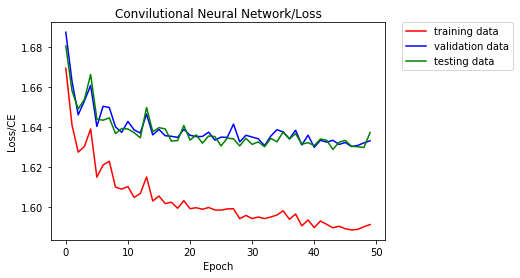

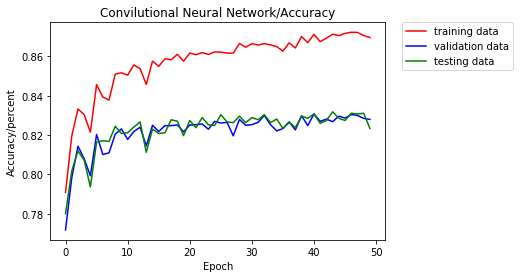

In [16]:
weight_decay = 0
train(trainData,newtrain,validData,newvalid,testData,newtest,weight_decay,filter_size, filter_number, 
                                         stride,pooling_size,out_units_layer1,out_units_layer2,
                                          use_dropout=False,use_l2=False,p=None)

## 2.3 Hyperparameter Investigation

### 1. L2 Normalization

weight decay = 
0.01
epoch   0:	 Loss=1.70,	Training Accuracy=86.7%
epoch   0:	 Loss=1.70,	Validation Accuracy=86.1%
epoch   0:	 Loss=1.70,	Testing Accuracy=86.6%
epoch   5:	 Loss=1.73,	Training Accuracy=85.9%
epoch   5:	 Loss=1.74,	Validation Accuracy=85.4%
epoch   5:	 Loss=1.73,	Testing Accuracy=86.2%
epoch  10:	 Loss=1.74,	Training Accuracy=85.3%
epoch  10:	 Loss=1.75,	Validation Accuracy=84.9%
epoch  10:	 Loss=1.74,	Testing Accuracy=85.7%
epoch  15:	 Loss=1.74,	Training Accuracy=86.3%
epoch  15:	 Loss=1.75,	Validation Accuracy=85.5%
epoch  15:	 Loss=1.74,	Testing Accuracy=86.8%
epoch  20:	 Loss=1.74,	Training Accuracy=86.2%
epoch  20:	 Loss=1.75,	Validation Accuracy=85.7%
epoch  20:	 Loss=1.75,	Testing Accuracy=86.0%
epoch  25:	 Loss=1.76,	Training Accuracy=85.3%
epoch  25:	 Loss=1.77,	Validation Accuracy=85.0%
epoch  25:	 Loss=1.76,	Testing Accuracy=85.3%
epoch  30:	 Loss=1.76,	Training Accuracy=85.3%
epoch  30:	 Loss=1.76,	Validation Accuracy=84.8%
epoch  30:	 Loss=1.76,	Testing 

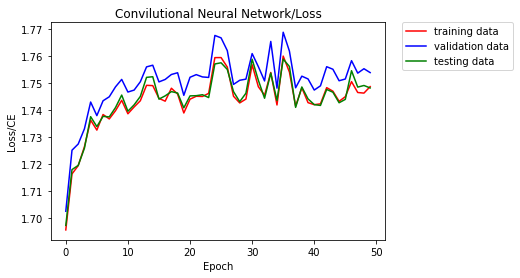

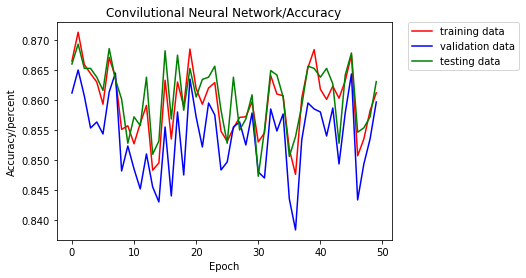

In [32]:
weight_decay_set = [0.01,0.1,0.5]

train(trainData,newtrain,validData,newvalid,testData,newtest,0.01,filter_size, filter_number, 
                                         stride,pooling_size,out_units_layer1,out_units_layer2,
                                          use_dropout=False,use_l2=True,p=None)

weight decay = 
0.1
epoch   0:	 Loss=2.30,	Training Accuracy=9.7%
epoch   0:	 Loss=2.30,	Validation Accuracy=10.3%
epoch   0:	 Loss=2.30,	Testing Accuracy=10.3%
epoch   5:	 Loss=2.30,	Training Accuracy=10.5%
epoch   5:	 Loss=2.30,	Validation Accuracy=8.9%
epoch   5:	 Loss=2.30,	Testing Accuracy=10.5%
epoch  10:	 Loss=2.30,	Training Accuracy=10.2%
epoch  10:	 Loss=2.30,	Validation Accuracy=9.9%
epoch  10:	 Loss=2.30,	Testing Accuracy=9.4%
epoch  15:	 Loss=2.30,	Training Accuracy=10.1%
epoch  15:	 Loss=2.30,	Validation Accuracy=10.0%
epoch  15:	 Loss=2.30,	Testing Accuracy=9.4%
epoch  20:	 Loss=2.30,	Training Accuracy=10.0%
epoch  20:	 Loss=2.30,	Validation Accuracy=9.9%
epoch  20:	 Loss=2.30,	Testing Accuracy=10.2%
epoch  25:	 Loss=2.30,	Training Accuracy=10.2%
epoch  25:	 Loss=2.30,	Validation Accuracy=9.9%
epoch  25:	 Loss=2.30,	Testing Accuracy=9.4%
epoch  30:	 Loss=2.30,	Training Accuracy=9.5%
epoch  30:	 Loss=2.30,	Validation Accuracy=11.1%
epoch  30:	 Loss=2.30,	Testing Accuracy=9

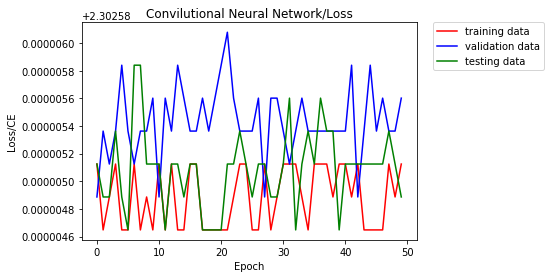

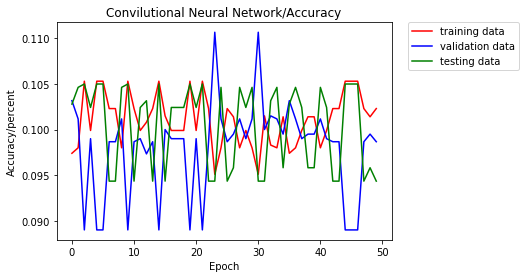

In [33]:
train(trainData,newtrain,validData,newvalid,testData,newtest,0.1,filter_size, filter_number, 
                                         stride,pooling_size,out_units_layer1,out_units_layer2,
                                          use_dropout=False,use_l2=True,p=None)

weight decay = 
0.5
epoch   0:	 Loss=2.30,	Training Accuracy=9.7%
epoch   0:	 Loss=2.30,	Validation Accuracy=10.3%
epoch   0:	 Loss=2.30,	Testing Accuracy=10.3%
epoch   5:	 Loss=2.30,	Training Accuracy=9.7%
epoch   5:	 Loss=2.30,	Validation Accuracy=10.3%
epoch   5:	 Loss=2.30,	Testing Accuracy=10.3%
epoch  10:	 Loss=2.30,	Training Accuracy=10.2%
epoch  10:	 Loss=2.30,	Validation Accuracy=9.9%
epoch  10:	 Loss=2.30,	Testing Accuracy=9.4%
epoch  15:	 Loss=2.30,	Training Accuracy=10.1%
epoch  15:	 Loss=2.30,	Validation Accuracy=10.0%
epoch  15:	 Loss=2.30,	Testing Accuracy=9.4%
epoch  20:	 Loss=2.30,	Training Accuracy=10.1%
epoch  20:	 Loss=2.30,	Validation Accuracy=10.0%
epoch  20:	 Loss=2.30,	Testing Accuracy=9.6%
epoch  25:	 Loss=2.30,	Training Accuracy=10.2%
epoch  25:	 Loss=2.30,	Validation Accuracy=9.9%
epoch  25:	 Loss=2.30,	Testing Accuracy=9.4%
epoch  30:	 Loss=2.30,	Training Accuracy=9.5%
epoch  30:	 Loss=2.30,	Validation Accuracy=11.1%
epoch  30:	 Loss=2.30,	Testing Accuracy=9

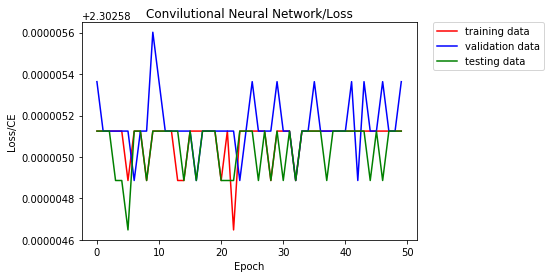

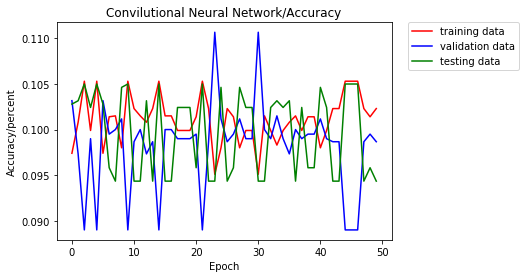

In [34]:
train(trainData,newtrain,validData,newvalid,testData,newtest,0.5,filter_size, filter_number, 
                                         stride,pooling_size,out_units_layer1,out_units_layer2,
                                          use_dropout=False,use_l2=True,p=None)

### 2. Dropout

dropout probability = 
0.9
epoch   0:	 Loss=1.66,	Training Accuracy=80.2%
epoch   0:	 Loss=1.67,	Validation Accuracy=79.1%
epoch   0:	 Loss=1.67,	Testing Accuracy=79.5%
epoch   5:	 Loss=1.62,	Training Accuracy=84.0%
epoch   5:	 Loss=1.64,	Validation Accuracy=82.0%
epoch   5:	 Loss=1.64,	Testing Accuracy=81.6%
epoch  10:	 Loss=1.62,	Training Accuracy=84.4%
epoch  10:	 Loss=1.65,	Validation Accuracy=81.5%
epoch  10:	 Loss=1.64,	Testing Accuracy=81.7%
epoch  15:	 Loss=1.61,	Training Accuracy=84.7%
epoch  15:	 Loss=1.65,	Validation Accuracy=81.5%
epoch  15:	 Loss=1.65,	Testing Accuracy=81.2%
epoch  20:	 Loss=1.60,	Training Accuracy=85.6%
epoch  20:	 Loss=1.64,	Validation Accuracy=82.3%
epoch  20:	 Loss=1.64,	Testing Accuracy=82.2%
epoch  25:	 Loss=1.60,	Training Accuracy=86.4%
epoch  25:	 Loss=1.63,	Validation Accuracy=83.0%
epoch  25:	 Loss=1.63,	Testing Accuracy=83.1%
epoch  30:	 Loss=1.60,	Training Accuracy=86.6%
epoch  30:	 Loss=1.63,	Validation Accuracy=83.2%
epoch  30:	 Loss=1.63,	Te

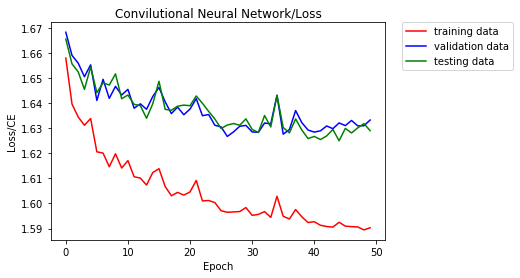

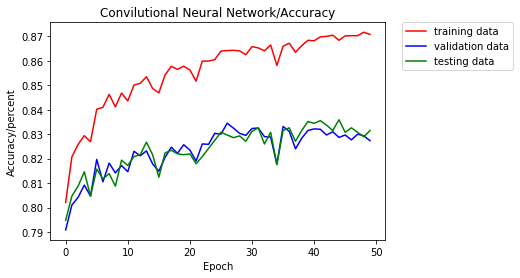

In [35]:
weight_decay = 0

train(trainData,newtrain,validData,newvalid,testData,newtest,weight_decay,filter_size, filter_number, 
                                         stride,pooling_size,out_units_layer1,out_units_layer2,
                                          use_dropout=True,use_l2=False,p=0.9)

dropout probability = 
0.75
epoch   0:	 Loss=1.56,	Training Accuracy=90.2%
epoch   0:	 Loss=1.57,	Validation Accuracy=89.2%
epoch   0:	 Loss=1.57,	Testing Accuracy=89.6%
epoch   5:	 Loss=1.52,	Training Accuracy=93.8%
epoch   5:	 Loss=1.54,	Validation Accuracy=91.7%
epoch   5:	 Loss=1.55,	Testing Accuracy=91.2%
epoch  10:	 Loss=1.51,	Training Accuracy=94.7%
epoch  10:	 Loss=1.55,	Validation Accuracy=91.5%
epoch  10:	 Loss=1.55,	Testing Accuracy=91.5%
epoch  15:	 Loss=1.51,	Training Accuracy=94.9%
epoch  15:	 Loss=1.54,	Validation Accuracy=91.9%
epoch  15:	 Loss=1.54,	Testing Accuracy=91.9%
epoch  20:	 Loss=1.51,	Training Accuracy=95.3%
epoch  20:	 Loss=1.54,	Validation Accuracy=92.2%
epoch  20:	 Loss=1.55,	Testing Accuracy=91.3%
epoch  25:	 Loss=1.51,	Training Accuracy=95.6%
epoch  25:	 Loss=1.54,	Validation Accuracy=92.1%
epoch  25:	 Loss=1.54,	Testing Accuracy=92.0%
epoch  30:	 Loss=1.50,	Training Accuracy=96.1%
epoch  30:	 Loss=1.53,	Validation Accuracy=92.8%
epoch  30:	 Loss=1.54,	T

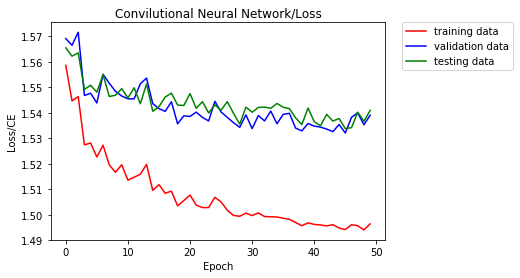

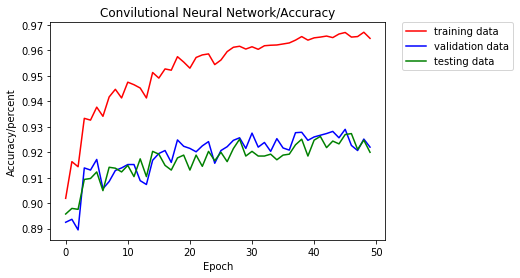

In [36]:
train(trainData,newtrain,validData,newvalid,testData,newtest,weight_decay,filter_size, filter_number, 
                                         stride,pooling_size,out_units_layer1,out_units_layer2,
                                          use_dropout=True,use_l2=False,p=0.75)

dropout probability = 
0.5
epoch   0:	 Loss=1.57,	Training Accuracy=89.1%
epoch   0:	 Loss=1.58,	Validation Accuracy=87.8%
epoch   0:	 Loss=1.58,	Testing Accuracy=88.4%
epoch   5:	 Loss=1.53,	Training Accuracy=92.8%
epoch   5:	 Loss=1.55,	Validation Accuracy=90.8%
epoch   5:	 Loss=1.56,	Testing Accuracy=90.6%
epoch  10:	 Loss=1.52,	Training Accuracy=94.1%
epoch  10:	 Loss=1.55,	Validation Accuracy=91.3%
epoch  10:	 Loss=1.55,	Testing Accuracy=91.3%
epoch  15:	 Loss=1.52,	Training Accuracy=94.2%
epoch  15:	 Loss=1.55,	Validation Accuracy=90.9%
epoch  15:	 Loss=1.55,	Testing Accuracy=91.1%
epoch  20:	 Loss=1.52,	Training Accuracy=94.6%
epoch  20:	 Loss=1.55,	Validation Accuracy=91.2%
epoch  20:	 Loss=1.56,	Testing Accuracy=90.4%
epoch  25:	 Loss=1.51,	Training Accuracy=94.8%
epoch  25:	 Loss=1.54,	Validation Accuracy=91.7%
epoch  25:	 Loss=1.55,	Testing Accuracy=91.3%
epoch  30:	 Loss=1.51,	Training Accuracy=95.2%
epoch  30:	 Loss=1.54,	Validation Accuracy=91.6%
epoch  30:	 Loss=1.54,	Te

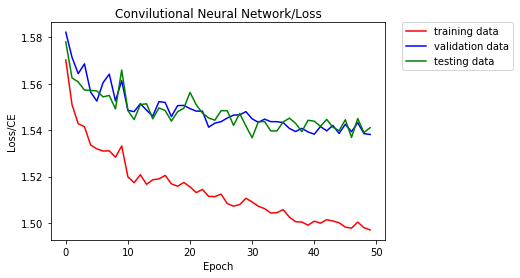

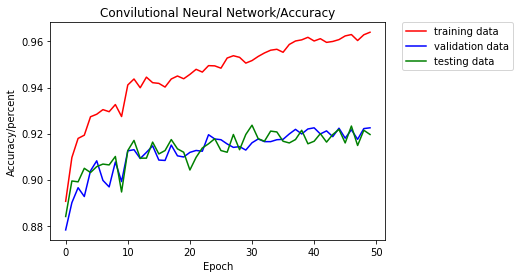

In [37]:
train(trainData,newtrain,validData,newvalid,testData,newtest,weight_decay,filter_size, filter_number, 
                                         stride,pooling_size,out_units_layer1,out_units_layer2,
                                          use_dropout=True,use_l2=False,p=0.5)